In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os

import sys
sys.path.insert(0, '../')

from scipy.ndimage import median_filter as medfilt

n_cadences = 3#int(24 * 60 * 0.5) #  a day

def median_filter(x, n_cadences=n_cadences):
    return medfilt(x, (n_cadences, ))

from libra import k62_all_transits

In [3]:
from interpacf import interpolated_acf

In [14]:
import kplr
client = kplr.API()

names = 'Kepler-62'
koi_number = 701

# Find the target KOI.
koi = client.koi(koi_number + 0.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=True)

lags = []
acfs = []

# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for i, lc in enumerate(lcs[9:10]):
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data

        time_q = hdu_data["time"] + 2454833
        flux_q = hdu_data["sap_flux"]
        err_q = hdu_data["sap_flux_err"]

        err_q /= np.nanmedian(flux_q)
        flux_q /= np.nanmedian(flux_q)
        not_nans = ~np.isnan(flux_q)
        p = np.polyfit(time_q[not_nans] - time_q[not_nans].mean(), flux_q[not_nans], 2)
        flux_q += 1 - np.polyval(p, time_q  - time_q[not_nans].mean())
        
        time.append(time_q)
        flux.append(flux_q)
        ferr.append(err_q)

flux = np.concatenate(flux)
not_nans = ~np.isnan(flux) & ~np.isnan(np.concatenate(time))
time = np.concatenate(time)[not_nans]
err = np.concatenate(ferr)[not_nans]/np.nanmax(flux)
flux = flux[not_nans]/np.percentile(flux[~np.isnan(flux)], 99)

sort = np.argsort(time)
time = time[sort]
flux = flux[sort] / k62_all_transits(time)[:, 0]
err = err[sort]

mask_flares = (flux < 0.99) | (flux > 1.002)

time = time[~mask_flares]
flux = flux[~mask_flares]
err = err[~mask_flares]

#np.savetxt('k62_medfilt.txt', np.vstack([time, flux, err]).T)

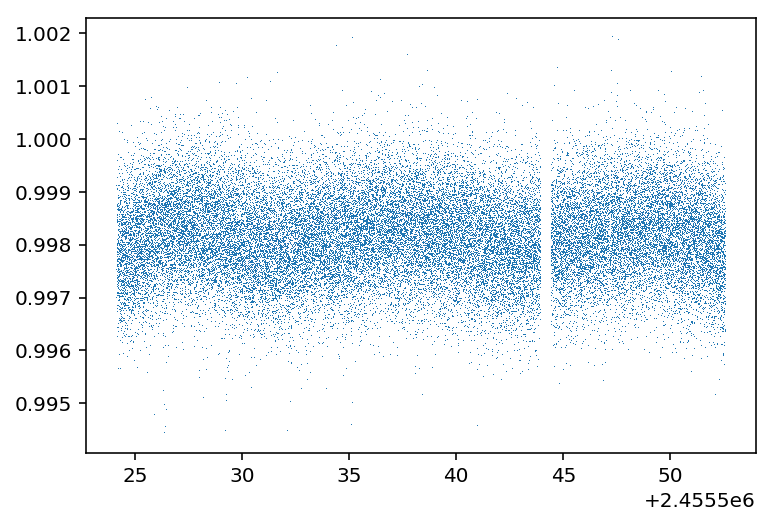

In [15]:
plt.plot(time, flux, ',')

gaps = np.argwhere(np.diff(time) > 100 * np.median(np.diff(time)))
chunks_time = []
chunks_flux = []

for i in range(len(gaps)-1):
    plt.axvline(time[gaps[i]])

    #if time[gaps[i]+1] > 2455640 and time[gaps[i+1]] < 2455900:
    chunks_time.append(time[gaps[i]+1:gaps[i+1]])
    chunks_flux.append(flux[gaps[i]+1:gaps[i+1]])

In [16]:
from celerite import terms
import celerite

kernel = terms.JitterTerm(log_sigma=np.log(np.nanmedian(err)))
kernel.freeze_parameter('log_sigma')

kernel += terms.SHOTerm(log_S0=np.log(1), log_Q=np.log(1/2**0.5), log_omega0=np.log(10)) 
kernel.freeze_parameter('terms[1]:log_Q')

# kernel += terms.RealTerm(log_a=0, log_c=np.log(20)) 
# kernel.freeze_parameter('terms[1]:log_c')

gp = celerite.GP(kernel, mean=1, fit_white_noise=True, fit_mean=True)
gp.compute(time)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

from scipy.optimize import minimize

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(flux, gp))
gp.set_parameter_vector(soln.x)
print(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

[-10.51457901  -2.10609699   0.99734427]
Final log-likelihood: 233699.35039134716


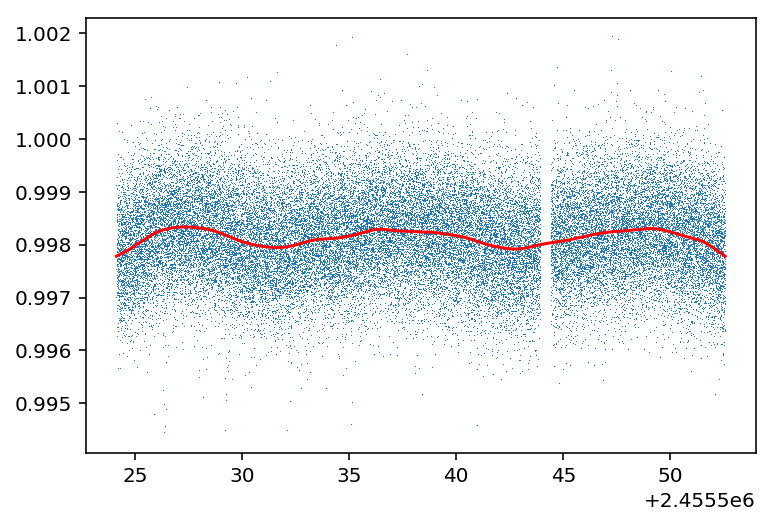

In [17]:
mu = gp.predict(flux, return_cov=False)#, return_var=True)
#std = np.sqrt(np.diag(var))
plt.plot(time, flux, ',')
plt.plot(time, mu, color='r')

Scale factor: 

In [22]:
from astropy.modeling.blackbody import blackbody_lambda
from scipy.optimize import fmin_powell

kepler_wavelength, kepler_trans = np.loadtxt('../libra/data/filters/kepler_response_hires1.txt', unpack=True)
kepler_wavelength /= 1000
nirspec_wavelength, nirspec_trans = np.loadtxt('../libra/data/etc/NIRSpec_S1600_prism_clear_throughput.csv', unpack=True, delimiter=',')

wavelengths = np.linspace(0.1, 10, 10000) * u.um
k62_teff = 4925

# Trampedach 2013 simulation 33
intensity_contrast = 0.12

def contrast_diff(p):
    return abs(np.trapz(blackbody_lambda(wavelengths, p[0]).value, wavelengths.value) / 
               np.trapz(blackbody_lambda(wavelengths, k62_teff).value, wavelengths.value) - intensity_contrast)

k62_cool = fmin_powell(contrast_diff, [4000])

hot_kepler = np.trapz(blackbody_lambda(wavelengths, k62_teff).value * 
                      np.interp(wavelengths.value, kepler_wavelength, kepler_trans) * wavelengths.value, 
                      wavelengths.value)

hot_nirspec = np.trapz(blackbody_lambda(wavelengths, k62_teff).value * 
                       np.interp(wavelengths.value, nirspec_wavelength, nirspec_trans) * wavelengths.value, 
                       wavelengths.value)

difference_1 = np.trapz((blackbody_lambda(wavelengths, k62_cool).value - blackbody_lambda(wavelengths, k62_teff).value)* 
                        np.interp(wavelengths.value, kepler_wavelength, kepler_trans) * wavelengths.value, 
                        wavelengths.value)

difference_2 = np.trapz((blackbody_lambda(wavelengths, k62_cool).value - blackbody_lambda(wavelengths, k62_teff).value)* 
                        np.interp(wavelengths.value, nirspec_wavelength, nirspec_trans) * wavelengths.value, 
                        wavelengths.value)

alpha = difference_2 * hot_kepler / (difference_1 * hot_nirspec)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 177


In [29]:
gp_model = alpha * (mu - np.median(mu)) + 1

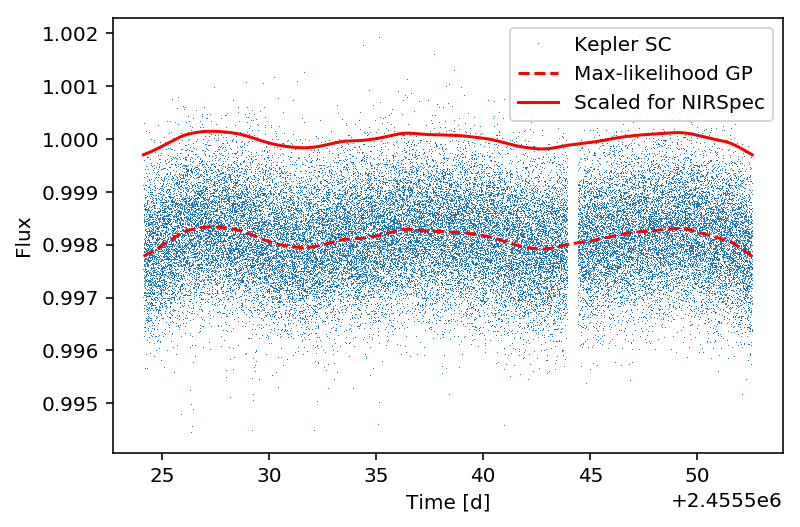

In [33]:
plt.plot(time, flux, ',', label='Kepler SC')
plt.plot(time, mu, color='r', ls='--', label='Max-likelihood GP')

plt.plot(time, gp_model, color='r', label='Scaled for NIRSpec')
plt.legend()
plt.xlabel('Time [d]')
plt.ylabel('Flux')
plt.savefig('k62_sc_acf.png', dpi=200, bbox_inches='tight')